# Multilinear regression model building for Rating Chagne

# Library

In [1]:
import sys
# sys.path.insert(1, r'C:/Users/User/OneDrive - Alpha Sherpa Capital/Desktop/general functions')
# data_path = r"C:\Users\User\OneDrive - Alpha Sherpa Capital\Desktop\data"

# import sys
sys.path.insert(1, r'C:\Users\karlf\OneDrive\桌面\Work\general functions')
sys.path.insert(1, r'C:\Users\karlf\OneDrive\桌面\Work\general functions\asc-library-temp-main')
data_path = r"C:\Users\karlf\OneDrive\桌面\Work\data"

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import yfinance as yf
import seaborn as sns
import plotly.express as px
import itertools
from tabulate import tabulate
from performance_stat_cal import *
import talib as ta

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import LeavePOut, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing

In [5]:
# Import the data
# data = pd.read_csv(f"{data_path}/anachange_database/anachange_rating_change_database_half_20220304.csv", index_col = 0)
data = pd.read_csv(f"anachange_rating_change_database_rf.csv", index_col = 0)
sensit_trades = pd.read_csv(f"{data_path}/anachange_database/historial_table_n_trades/all_historical_sensit_trades.csv", index_col = 0)
orig_trades = pd.read_csv(f"{data_path}/anachange_database/historial_table_n_trades/all_historical_trades.csv", index_col = 0)

data = data.loc[data.max_risk > 2000]
sensit_trades = sensit_trades.loc[sensit_trades.max_risk > 2000]
orig_trades = orig_trades.loc[orig_trades.max_risk > 2000]

data.entry_date = pd.to_datetime(data.entry_date).dt.date
sensit_trades.entry_date = pd.to_datetime(sensit_trades.entry_date).dt.date
orig_trades.entry_date = pd.to_datetime(orig_trades.entry_date).dt.date

# Fee 
sensit_trades.d0_r = sensit_trades.d0_r + sensit_trades.fee_in_r  # original sensit trades is after fee
orig_trades.d0_r = orig_trades.d0_r + orig_trades.fee_in_r  # original sensit trades is after fee

# Drop null
data.dropna(subset=["d0_open", "d0_close", "atr", "prev1_close", 'volume_d_10_sma'], inplace=True)

In [6]:
data['uid_tdb'] = data.ticker + data.entry_date.apply(lambda x: str(x)) + data.broker

## Europe ONLY

In [7]:
region_selected = 'Europe'
data = data.loc[data.exch_region == region_selected]
sensit_trades = sensit_trades.loc[sensit_trades.exch_region == region_selected]
orig_trades = orig_trades[orig_trades.exch_region == region_selected]

In [8]:
# Add gap columns
def getting_gap(d0_open, prev1_close, atr):
    if math.isnan(prev1_close): return np.nan
    if math.isnan(atr) or (atr < 0.00001): return np.nan
    gap = (d0_open - prev1_close)
    gap_in_atr = gap/atr
    return gap_in_atr
data["gap_in_atr"] = data.apply(lambda x: getting_gap(x.d0_open, x.prev1_close, x.atr) , axis = 1)

In [9]:
def column_groupping(seies, lb, ud, num_bins):
    bins = np.linspace(lb, ud, num_bins)
    bins_size = bins[1] - bins[0]
    return [bins[i-1] for i in np.digitize( seies, bins, right = True)]

data['max_risk_grp'] = column_groupping(data.max_risk, 0, 100000, 41)
data['gap_in_atr_grp'] = column_groupping(data.gap_in_atr, -3, 3, 13)

# Earnings label

In [10]:
def earnings_encoder(ern):
    if (ern == 'not after earnings') or ('undefined' in ern ):
        return 'not'
    if 'after' in ern:
        if int(re.split(' ', ern)[0]) == 1:
            return 'ytd_enr'
        elif int(re.split(' ', ern)[0]) == 0:
            return 'today_enr'
        else:
            return 'after_few_days'
    elif 'before' in ern:
        if int(re.split(' ', ern)[0]) <5 :
            return 'within_1_week'
        if int(re.split(' ', ern)[0]) >=5 :
            return 'around_half_month'

In [11]:
data['ern_labe_clean'] = data.ern_label.apply(earnings_encoder)

# Rating Change Rationale Label

In [12]:
factor = 'gics2'
threshold = 3
gics1_released_a_lot_pd = pd.DataFrame()
for date, data_group in data.groupby(by="entry_date"):
    gics1_occurrence = data_group[factor].value_counts()
    gics1_released_a_lot = gics1_occurrence.loc[gics1_occurrence>=threshold].index
    if len(gics1_released_a_lot) != 0:
        gics1_released_a_lot_pd = pd.concat([gics1_released_a_lot_pd, data_group.loc[(data_group.gics1.isin(gics1_released_a_lot)) ] ])
        
gics2_unacceptable_index = gics1_released_a_lot_pd.index
data['gics2_mulitple'] = 0
data.loc[gics2_unacceptable_index, 'gics2_mulitple'] = 1

In [13]:
factor = 'broker'
threshold = 3
gics1_released_a_lot_pd = pd.DataFrame()
for date, data_group in data.groupby(by="entry_date"):
    gics1_occurrence = data_group[factor].value_counts()
    gics1_released_a_lot = gics1_occurrence.loc[gics1_occurrence>=threshold].index
    if len(gics1_released_a_lot) != 0:
        gics1_released_a_lot_pd = pd.concat([gics1_released_a_lot_pd, data_group.loc[data_group[factor].isin(gics1_released_a_lot)] ])
            
broker_unacceptable_index = gics1_released_a_lot_pd.index
data['broker_mulitple'] = 0
data.loc[broker_unacceptable_index, 'broker_mulitple'] = 1

In [14]:
factor = 'ticker'
threshold = 2
gics1_released_a_lot_pd = pd.DataFrame()
for date, data_group in data.groupby(by="entry_date"):
    gics1_occurrence = data_group[factor].value_counts()
    gics1_released_a_lot = gics1_occurrence.loc[gics1_occurrence>=threshold].index
    if len(gics1_released_a_lot) != 0:
        gics1_released_a_lot_pd = pd.concat([gics1_released_a_lot_pd, data_group.loc[data_group[factor].isin(gics1_released_a_lot)] ])
        
ticker_multiple_index = gics1_released_a_lot_pd.index
data['ticker_mulitple'] = 0
data.loc[ticker_multiple_index, 'ticker_mulitple'] = 1

# Null checking

In [15]:
print(f'\n{len(data.loc[data.isna().any(axis = 1)])} of rows with null, {len(data.loc[data.isna().any(axis = 1)])/len(data)} of data')


8682 of rows with null, 0.3132147624373174 of data


In [16]:
broker_selected = 'Barclays'
# data = data.loc[data.broker == broker_selected]


# sensit_trades = sensit_trades.loc[sensit_trades.broker == broker_selected]
# orig_trades = orig_trades[orig_trades.broker == broker_selected]

# Exploratory data analysis (EDA)

In [17]:
"""
Here I use the original simple mean method to genereate the score and check whether it's correlated with d0_r
Intuition: a slightly upwarding line (x: Score, y: d0_r)
Original version of model and code is wrote by Geroge and Amanda
"""

"\nHere I use the original simple mean method to genereate the score and check whether it's correlated with d0_r\nIntuition: a slightly upwarding line (x: Score, y: d0_r)\nOriginal version of model and code is wrote by Geroge and Amanda\n"

## Simple mean combination scoring model

In [18]:
train_test_date = sorted(set(data.entry_date))[:- int(len(set(data.entry_date))*0.2)]
train_test_date_df = pd.Series(train_test_date)
holdout_date = sorted(set(data.entry_date))[- int(len(set(data.entry_date))*0.2):]
holdout_date_df = pd.Series(holdout_date)

In [19]:
factors =  [ 'broker', 'ticker', 'side', 'gics1', 'market_cap_grp',  'max_risk_grp', 'trend_type', 'rating_chg_strength',]

pending_encoder = ['rating_chg_strength', 'release_period', 'trend_type', 'ern_labe_clean', 'gics2_mulitple', 'broker_mulitple', 'ticker_mulitple']
# gap_in_atr_grp is hard to be considered

# optimal factor:  'broker', 'ticker', 'side', 'gics1', 'market_cap_grp',  'max_risk_grp', 'trend_type', 'rating_chg_strength' , 'release_period'

In [20]:
def generate_combinations(factors):
    com_list = []
    for i in range(2, 3):
        com_list += list(itertools.combinations(factors, i))
    return com_list

def add_combination_scores(dataset, testset, r_used='d0_r'):
    testset.reset_index(drop=True, inplace=True)
    score_cols_name = []
    
    for combination in combinations:
        # create dict for mapping score
        element_list = list(combination)
        table = pd.pivot_table(dataset, values=r_used, index=element_list, aggfunc=np.mean)
        dict_for_combination = table.to_dict()[r_used]
        
        # map the score and add column to df
        var_name = 'score'
        for feature in element_list: var_name +=  f'__{feature}'
        score_cols_name.append(var_name)
        if len(element_list) == 1: combined_value = testset[element_list[0]]
        else: combined_value = pd.Series(testset[element_list].to_records(index=False).tolist())
        testset[var_name] = combined_value.map(dict_for_combination)
        
    return score_cols_name, testset

def get_trade_record(data, sort_by='score', max_trade=6, max_skew=1):
    trade_record_uid_tdb = []
    for date, data_group in data.groupby('entry_date'):
        selected_trades = _select_trades_with_portfolio_constraint(data_group, sort_by=sort_by, max_trade=max_trade, max_skew=max_skew)
        trade_record_uid_tdb = trade_record_uid_tdb + list(selected_trades['uid_tdb'])
        
    trade_record = data[data['uid_tdb'].isin(trade_record_uid_tdb)]
    return trade_record


In [21]:
def _select_trades_with_portfolio_constraint(df, sort_by="d0_exp", max_trade=6, max_skew=2):
    """
        This function selects trades with portfolio constraints (based on a df with 'side' and score).
        
        - df: DataFrame with a list of possible trades
        
        - sort_by: 'score' column, used to rank the trades
        
        - max_trades: maximum trades from this DataFrame
        
        - max_skew: maximum skewness (i.e. net long/short position)
        """
    try:
        df = df[df["screening"] == ""].copy()
    except:
        pass

    df.sort_values(by=sort_by, ascending=False, inplace=True)

    if len(df) == 0:
        return df

    long_queue = df[df["side"] == "long"]
    short_queue = df[df["side"] == "short"]

    pending_trades = pd.DataFrame()
    min_length = min(len(long_queue), len(short_queue))

    if max_skew == 0:
        min_length_for_balance = int(min(min_length, math.floor(max_trade / 2)))
        pending_trades = pd.concat(
            [
                long_queue.iloc[:min_length_for_balance],
                short_queue.iloc[:min_length_for_balance],
            ]
        )

    elif max_skew > 0:
        for i in range(min_length + max_skew):
            if i < len(long_queue):
                pending_trades = pd.concat([pending_trades, long_queue.iloc[[i]]])
            if i < len(short_queue):
                pending_trades = pd.concat([pending_trades, short_queue.iloc[[i]]])
            trades_skew = abs(np.where(pending_trades["side"] == "long", 1, -1).sum())
            if trades_skew == max_skew:
                break
            if len(pending_trades) >= max_trade:
                break

    return pending_trades


In [22]:
def simple_mean_scoring_system_trades(region, ):
    regional_data = data.loc[data.exch_region == region]
    dataset_ = regional_data.loc[regional_data.entry_date.isin(train_test_date_df)]
    testset_ = regional_data.loc[regional_data.entry_date.isin(holdout_date_df)]

    score_cols_name, testset = add_combination_scores(dataset_, testset_, r_used='d0_r_ex_sl')

    # remove duplicated score columns
    score_col_list = []
    testset = testset.loc[:,~testset.columns.duplicated()]
    for col in testset.columns:
        if 'score_' in col: score_col_list.append(col)

    # simple average score
    testset['score'] = testset[score_col_list].mean(axis=1)
    testset_after_scoring = testset.copy()

    testset = testset[(testset.max_risk > 2000) & (testset['score'] >= 0.1)]
    trade_record = get_trade_record(testset, sort_by='score', max_trade=6, max_skew=1)
    return trade_record, testset_after_scoring

In [23]:
combinations = generate_combinations(factors)

In [24]:
regional_smss_trades, regional_sensit_trades, regional_orig_trades, exp_list_smss, exp_list_sensit, exp_list_orig  = {}, {}, {}, [], [], []
region_list = [region_selected]
for region in region_list:
    
    regional_smss_trades[region], testset_after_scoring = simple_mean_scoring_system_trades(region)
    regional_sensit_trades[region] = sensit_trades.loc[(sensit_trades.exch_region == region) &  (sensit_trades.entry_date >= regional_smss_trades[region].entry_date.iloc[0])& (sensit_trades['New Score'] > 0)]
    regional_orig_trades[region] = orig_trades.loc[(orig_trades.exch_region == region) & (orig_trades.entry_date >= regional_smss_trades[region].entry_date.iloc[0])& (orig_trades['Score'] > 0)]
    
    
    performance_stat_col , performance_stat_smss = performance_stat_calculation(regional_smss_trades[region], 'd0_r', 1)
    performance_stat_col , performance_stat_sensit = performance_stat_calculation(regional_sensit_trades[region], 'd0_r', 1)
    performance_stat_col , performance_stat_orig = performance_stat_calculation(regional_orig_trades[region], 'd0_r', 1)
    
    exp_list_smss.append(performance_stat_smss)
    exp_list_sensit.append(performance_stat_sensit)
    exp_list_orig.append(performance_stat_orig)

In [25]:
print(factors )
print(f'{regional_smss_trades["Europe"].entry_date.value_counts().mean()} trades per day \n')
print('>0.1 score, 2 combination (3 is param')
performance_stats_smss = pd.DataFrame(exp_list_smss, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stats_smss, headers = ["SMSS Model"] + performance_stat_col))
print('\n')
performance_stat_sensit = pd.DataFrame(exp_list_sensit, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stat_sensit, headers = ["Sensit Model"] + performance_stat_col))
print('\n')
performance_stat_orig = pd.DataFrame(exp_list_orig, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stat_orig, headers = ["Original Model"] + performance_stat_col))

['broker', 'ticker', 'side', 'gics1', 'market_cap_grp', 'max_risk_grp', 'trend_type', 'rating_chg_strength']
4.547808764940239 trades per day 

>0.1 score, 2 combination (3 is param
SMSS Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
------------  ---------  --------------------------  ----------------  -----------  ------------  -----------------------------
Europe           219.94                      219.94              2283      0.52869       0.09634                        0.09634


Sensit Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
--------------  ---------  --------------------------  ----------------  -----------  ------------  -----------------------------
Europe             116.24                      116.24              2279      0.51031         0.051                          0.051


Original Model      Total R    Total R (

In [26]:
temp = regional_smss_trades["Europe"]
temp1 = sensit_trades.loc[(sensit_trades.exch_region == region) &  (sensit_trades.entry_date >= regional_smss_trades[region].entry_date.iloc[0]) & (sensit_trades['New Score'] > 0)]
temp2 = orig_trades.loc[(orig_trades.exch_region == region) &  (orig_trades.entry_date >= regional_smss_trades[region].entry_date.iloc[0]) & (orig_trades.Score > 0)]

temp['year_month'] = temp.entry_date.apply(lambda x: str(x.year)) + ' '+ temp.entry_date.apply(lambda x: str(x.month))
temp1['year_month'] = temp1.entry_date.apply(lambda x: str(x.year)) + ' '+ temp1.entry_date.apply(lambda x: str(x.month))
temp2['year_month'] = temp2.entry_date.apply(lambda x: str(x.year)) + ' '+ temp2.entry_date.apply(lambda x: str(x.month))

pd.DataFrame({'smss':temp.groupby('year_month').sum().d0_r, 
'sensit': temp1.groupby('year_month').sum().d0_r,
'orig': temp2.groupby('year_month').sum().d0_r})

,smss,sensit,orig
year_month,,,
2019 12,-1.259,3.760,-3.609
2020 1,21.115,4.556,4.811
2020 10,8.921,0.655,-3.556
2020 11,20.376,15.534,22.873
2020 12,8.349,10.978,0.902
2020 2,21.210,4.366,6.394
2020 3,4.389,12.538,15.958
2020 4,9.313,2.418,5.550
2020 5,19.982,14.214,6.107


In [31]:
regional_smss_trades[region][['entry_date'	,'ticker'	,'broker'	,'atr'	,'side'	, 'd0_open',	'd0_high',	'd0_low',	'd0_close']].to_csv('smss_trades.csv')

## Score and d0 r correlation

In [393]:
fig = px.scatter(testset_after_scoring, x = "score", y = 'd0_r_ex_sl',  width = 1200, height = 500, trendline = "ols")
fig.add_vline(x = 0, line_width = 3, line_dash = "dash", line_color = "gray")
fig.add_hline(y = 0, line_width = 3, line_dash = "dash", line_color = "gray")
fig.update_layout( title=f'Scatter Plot for Europe ')
fig.show()

# Train test holdout split

In [395]:
"""
Split by DATE!!
If we use the train set to generate the scoring the scoring columns, it invloves the current r, so it will overfit, the weighting will be gg
If we hold out a dataset and use it for scoring, the structure will totally change because of the score change
The best way to solve it is use: Kfold, although it will involves future data, we can also consider time-series kfold
"""

'\nSplit by DATE!!\nIf we use the train set to generate the scoring the scoring columns, it invloves the current r, so it will overfit, the weighting will be gg\nIf we hold out a dataset and use it for scoring, the structure will totally change because of the score change\nThe best way to solve it is use: Kfold, although it will involves future data, we can also consider time-series kfold\n'

In [396]:
"""
Now we are going to use LOOCV to generate a dataset with score for feature selection
-> time consuming, we are going to use k-fold instead of LOOCV
"""

'\nNow we are going to use LOOCV to generate a dataset with score for feature selection\n-> time consuming, we are going to use k-fold instead of LOOCV\n'

In [397]:
"""
2022-02-10:
originally we remain 5 years data for scoring: 2011-2015
keep updating the scoring set, trainset: 2016-2018
keep updating the scoring set, testset: 2019-2020
"""

'\n2022-02-10:\noriginally we remain 5 years data for scoring: 2011-2015\nkeep updating the scoring set, trainset: 2016-2018\nkeep updating the scoring set, testset: 2019-2020\n'

In [398]:
original_scoring_set = data.loc[data.entry_date <= datetime.date(2017,12,31)]
train_set_data = data.loc[(data.entry_date > datetime.date(2017,12,31)) & (data.entry_date <= datetime.date(2020,12,31))]
holdout_set_data = data.loc[(data.entry_date > datetime.date(2020,12,31))]

## Train set scores columns

In [399]:
train_set_data_with_score = pd.DataFrame()
train_set_data_date = sorted(set(train_set_data.entry_date))
prev_date = train_set_data_date[0]

for i in (np.linspace(0, len(train_set_data_date), 50)-1)[1:].astype(int):
    upper_bound_date = train_set_data_date[i]
    score_cols_name, testset = add_combination_scores(data.loc[(data.entry_date<prev_date)], 
                                                      train_set_data.loc[(train_set_data.entry_date>=prev_date) & 
                                                                         (train_set_data.entry_date<upper_bound_date) & 
                                                                         (train_set_data.entry_date != upper_bound_date)], r_used='d0_r_ex_sl')
    prev_date = upper_bound_date
    
    train_set_data_with_score = pd.concat([train_set_data_with_score, testset])
train_set_data_with_score.sort_values(by = 'entry_date', inplace = True)

## Test set scores columns

In [400]:
holdout_set_data_with_score = pd.DataFrame()
holdout_set_data_date = sorted(set(holdout_set_data.entry_date))
prev_date = holdout_set_data_date[0]

for i in (np.linspace(0, len(holdout_set_data_date), 50)-1)[1:].astype(int):
    upper_bound_date = holdout_set_data_date[i]
    score_cols_name, testset = add_combination_scores(data.loc[(data.entry_date<prev_date)], 
                                                      holdout_set_data.loc[(holdout_set_data.entry_date>=prev_date) & 
                                                                           (holdout_set_data.entry_date<upper_bound_date) & 
                                                                           (holdout_set_data.entry_date != upper_bound_date)], r_used='d0_r_ex_sl')
    prev_date = upper_bound_date
    
    holdout_set_data_with_score = pd.concat([holdout_set_data_with_score, testset])
holdout_set_data_with_score.sort_values(by = 'entry_date', inplace = True)

## Null Handling
fill with previous mean (time dependent data), the first data with na we fill with 0 (just one data)

In [401]:
null_pct = train_set_data_with_score[score_cols_name].isna().sum()/len(train_set_data_with_score)

In [402]:
for i in null_pct.loc[null_pct > 0.5].index:
    print(f'remove {i}')
    score_cols_name.remove(i)

In [403]:
# Fillna
train_set_data_with_score[score_cols_name] = train_set_data_with_score[score_cols_name].fillna(train_set_data_with_score[score_cols_name].expanding().mean()).fillna(0)
holdout_set_data_with_score[score_cols_name] = holdout_set_data_with_score[score_cols_name].fillna(holdout_set_data_with_score[score_cols_name].expanding().mean()).fillna(0)

In [404]:
train_set_with_score = train_set_data_with_score.copy()
holdout_set_with_score = holdout_set_data_with_score.copy()

# Feature Engineering

score_col_list = []
for col in dataset_with_score.columns:
    if 'score_' in col: score_col_list.append(col)

In [405]:
score_col_list = score_cols_name.copy()
data_for_feature_corr_analsysis = train_set_with_score.copy()

## Correlation Matrix

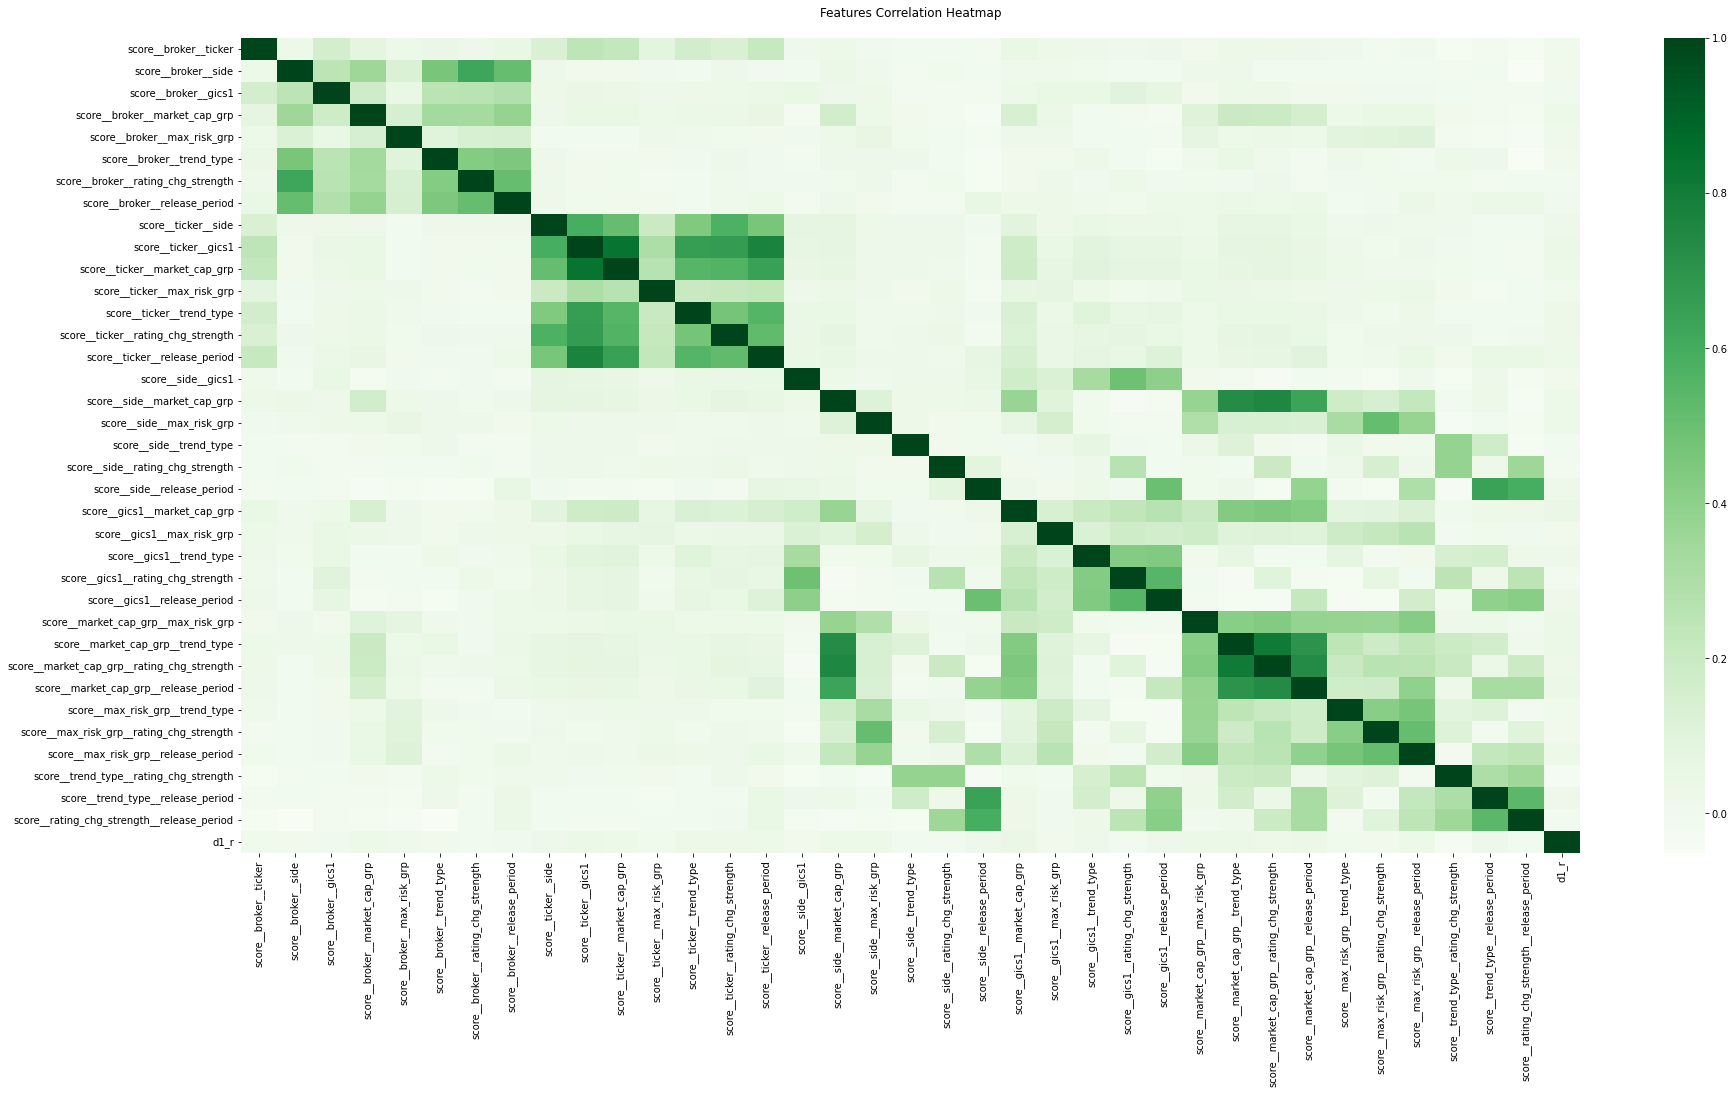

In [406]:
plt.figure(figsize=(30,15))
sns.heatmap(data_for_feature_corr_analsysis[score_col_list + ['d1_r']].corr(), cmap=plt.cm.Greens).set_title('Features Correlation Heatmap\n')
plt.show()

# Wrapped Method

## Backward Elimination by p-value

In [407]:
X_1 = sm.add_constant(data_for_feature_corr_analsysis[score_col_list])
y = data_for_feature_corr_analsysis.d0_r_ex_sl
model = sm.OLS(y,X_1).fit()
pvalues_sorted = model.pvalues.sort_values()
model.pvalues.sort_values()

score__broker__market_cap_grp                0.017
score__side__gics1                           0.098
score__market_cap_grp__release_period        0.117
score__market_cap_grp__rating_chg_strength   0.130
score__ticker__market_cap_grp                0.132
score__side__trend_type                      0.173
score__gics1__release_period                 0.223
score__gics1__max_risk_grp                   0.290
score__side__max_risk_grp                    0.314
score__gics1__market_cap_grp                 0.337
score__trend_type__release_period            0.340
score__side__market_cap_grp                  0.343
score__broker__max_risk_grp                  0.374
score__side__release_period                  0.376
score__gics1__trend_type                     0.399
score__side__rating_chg_strength             0.425
score__ticker__release_period                0.453
score__max_risk_grp__release_period          0.490
score__broker__rating_chg_strength           0.536
score__max_risk_grp__rating_chg

In [312]:
cols = score_col_list.copy()
pmax = 1
while (len(cols)>0):
    p = []
    X_1 = data_for_feature_corr_analsysis[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05): cols.remove(feature_with_p_max)
    else: break
selected_features_BE = cols

In [313]:
"""
We keep the independent variable with >0.1 p-value and plot their correlation matrix for further selection
and we find that scores related to 'ticker' should be groupped to 'score__ticker__side' (largest d0_r correlation)
"""

"\nWe keep the independent variable with >0.1 p-value and plot their correlation matrix for further selection\nand we find that scores related to 'ticker' should be groupped to 'score__ticker__side' (largest d0_r correlation)\n"

In [314]:
del_scores_list = []
for col in selected_features_BE:
    correlated_col = data_for_feature_corr_analsysis[selected_features_BE].corr()[col].loc[(data_for_feature_corr_analsysis[selected_features_BE].corr()>0.6)[col]].index.to_list()
    correlated_col.remove(col)
    benchmark = pvalues_sorted[col]
    for high_correlation_col in correlated_col:
        if pvalues_sorted[high_correlation_col] >= benchmark: del_scores_list.append(col)
        else: del_scores_list.append(high_correlation_col)

In [315]:
selected_features_BE_corrdel = [i for i in selected_features_BE if i not in set(del_scores_list)]

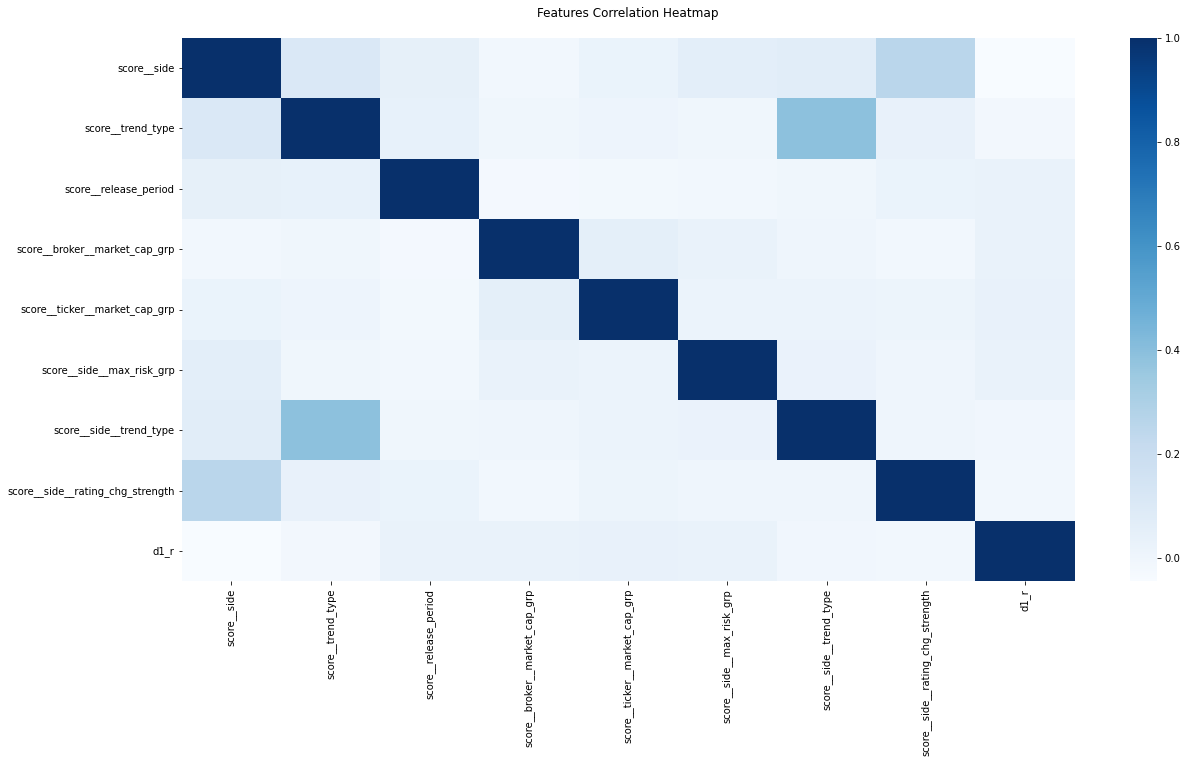

In [316]:
plt.figure(figsize=(20,10))
sns.heatmap(data_for_feature_corr_analsysis[selected_features_BE_corrdel + ['d1_r']].corr(), cmap=plt.cm.Blues).set_title('Features Correlation Heatmap\n')
plt.show()

In [317]:
# group the ticker related score as score__ticker__side
selected_features_BE_corrdel

['score__side',
 'score__trend_type',
 'score__release_period',
 'score__broker__market_cap_grp',
 'score__ticker__market_cap_grp',
 'score__side__max_risk_grp',
 'score__side__trend_type',
 'score__side__rating_chg_strength']

# Linear Regression

In [362]:
x = train_set_with_score[selected_features_BE_corrdel]
y = train_set_with_score.d0_r

In [363]:
reg = LinearRegression().fit(x, y)
print(f'model R squre {reg.score(x, y)}')

model R squre 0.005387476029903082


In [364]:
holdout_set_with_score['d0_r_pred'] = reg_lasso.predict(holdout_set_with_score[score_cols_name])

In [368]:
regional_reg_trades, exp_list_reg,  = {}, []
for region in region_list:
    temp_data = holdout_set_with_score.loc[holdout_set_with_score.exch_region == region]
    temp_data = temp_data[(temp_data['d0_r_pred'] >= 0.1)]
    trade_record = get_trade_record(temp_data, sort_by='d0_r_pred', max_trade=6, max_skew=1)
    regional_reg_trades[region] = trade_record
    performance_stat_col , performance_stat_reg= performance_stat_calculation(trade_record, 'd0_r', 1)
    exp_list_reg.append(performance_stat_reg)

In [369]:
regional_sensit_trades, regional_orig_trades, exp_list_sensit, exp_list_orig  = {}, {}, [], []
region_list = [region_selected]
for region in region_list:
    
    regional_sensit_trades[region] = sensit_trades.loc[(sensit_trades.exch_region == region) &  (sensit_trades.entry_date >= regional_reg_trades[region].entry_date.iloc[0])]
    regional_orig_trades[region] = orig_trades.loc[(orig_trades.exch_region == region) & (orig_trades.entry_date >= regional_reg_trades[region].entry_date.iloc[0])]
    
    
    performance_stat_col , performance_stat_sensit = performance_stat_calculation(regional_sensit_trades[region], 'd0_r', 1)
    performance_stat_col , performance_stat_orig = performance_stat_calculation(regional_orig_trades[region], 'd0_r', 1)
    
    exp_list_sensit.append(performance_stat_sensit)
    exp_list_orig.append(performance_stat_orig)

In [370]:
performance_stats_reg = pd.DataFrame(exp_list_reg, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stats_reg, headers = ["Reg Model"] + performance_stat_col))
print('\n')
performance_stats_smss = pd.DataFrame(exp_list_smss, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stats_smss, headers = ["SMSS Model"] + performance_stat_col))
print('\n')
performance_stat_sensit = pd.DataFrame(exp_list_sensit, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stat_sensit, headers = ["Sensit Model"] + performance_stat_col))
print('\n')
performance_stat_orig = pd.DataFrame(exp_list_orig, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stat_orig, headers = ["Original Model"] + performance_stat_col))

Reg Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
-----------  ---------  --------------------------  ----------------  -----------  ------------  -----------------------------
Europe           14.07                       14.07               146       0.5274       0.09635                        0.09635


SMSS Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
------------  ---------  --------------------------  ----------------  -----------  ------------  -----------------------------
Europe           208.36                      208.36              2247      0.52692       0.09273                        0.09273


Sensit Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
--------------  ---------  --------------------------  ----------------  -----------  ------------  -

# Lasso Regression

In [352]:
lasso_x = train_set_with_score[score_cols_name]
lasso_y = train_set_with_score.d0_r

In [353]:
reg_lasso = LassoCV(cv=1000, random_state=0).fit(lasso_x, lasso_y)

In [354]:
reg_lasso.score(lasso_x, lasso_y)

0.0024247053704515853

In [355]:
holdout_set_with_score['d0_r_pred'] = reg_lasso.predict(holdout_set_with_score[score_cols_name])

In [356]:
regional_reg_trades, exp_list_reg,  = {}, []
for region in region_list:
    temp_data = holdout_set_with_score.loc[holdout_set_with_score.exch_region == region]
    temp_data = temp_data[(temp_data['d0_r_pred'] >= 0)]
    trade_record = get_trade_record(temp_data, sort_by='d0_r_pred', max_trade=6, max_skew=1)
    regional_reg_trades[region] = trade_record
    performance_stat_col , performance_stat_reg= performance_stat_calculation(trade_record, 'd0_r', 1)
    exp_list_reg.append(performance_stat_reg)

In [357]:
performance_stats_reg = pd.DataFrame(exp_list_reg, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stats_reg, headers = ["LASSO Model"] + performance_stat_col))
print('\n')
performance_stats_smss = pd.DataFrame(exp_list_smss, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stats_smss, headers = ["SMSS Model"] + performance_stat_col))
print('\n')
performance_stat_sensit = pd.DataFrame(exp_list_sensit, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stat_sensit, headers = ["Sensit Model"] + performance_stat_col))
print('\n')
performance_stat_orig = pd.DataFrame(exp_list_orig, columns= performance_stat_col, index = region_list)
print(tabulate(performance_stat_orig, headers = ["Original Model"] + performance_stat_col))

LASSO Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
-------------  ---------  --------------------------  ----------------  -----------  ------------  -----------------------------
Europe             89.76                       89.76              1399      0.51036       0.06416                        0.06416


SMSS Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
------------  ---------  --------------------------  ----------------  -----------  ------------  -----------------------------
Europe           208.36                      208.36              2247      0.52692       0.09273                        0.09273


Sensit Model      Total R    Total R (Same Cash Pos.)    Num. of trades    Hit Ratio    Expectancy    Expectancy (Same Cash Pos.)
--------------  ---------  --------------------------  ----------------  -----------  ---------

# Random Forest

In [318]:
from sklearn.ensemble import RandomForestClassifier

In [319]:
train_set_with_score_rf = train_set_with_score.copy()

vix_rsi = ta.RSI(yf.download('^VIX').Close, timeperiod= 10)
vix_rsi.index = pd.to_datetime(pd.Series(vix_rsi.index)).dt.date

In [371]:
label_ec_strength = LabelEncoder()
train_set_with_score_rf['rating_chg_strength_encoded'] = label_ec_strength.fit_transform(train_set_with_score_rf[['rating_chg_strength']])

label_ec_release = LabelEncoder()
train_set_with_score_rf['release_period_encoded'] = label_ec_release.fit_transform(train_set_with_score_rf[['release_period']])

onehot_ec_trend = OneHotEncoder()
trend_type_enconded = pd.DataFrame(onehot_ec_trend.fit_transform(train_set_with_score_rf[['trend_type']]).toarray())

onehot_ec_ern = OneHotEncoder()
ern_labe_clean_encoded = pd.DataFrame(onehot_ec_ern.fit_transform(train_set_with_score_rf[['ern_labe_clean']]).toarray())

label_ec_gics2m = LabelEncoder()
train_set_with_score_rf['gics2_mulitple_encoded'] = label_ec_gics2m.fit_transform(train_set_with_score_rf[['gics2_mulitple']])

label_ec_brokerm = LabelEncoder()
train_set_with_score_rf['broker_mulitple_encoded'] = label_ec_brokerm.fit_transform(train_set_with_score_rf[['broker_mulitple']])

label_ec_tickerm = LabelEncoder()
train_set_with_score_rf['ticker_mulitple_encoded'] = label_ec_tickerm.fit_transform(train_set_with_score_rf[['ticker_mulitple']])

label_ec_side = LabelEncoder()
train_set_with_score_rf['side_encoded'] = label_ec_side.fit_transform(train_set_with_score_rf[['side']])

# train_set_with_score_rf['vix_rsi'] = train_set_with_score_rf.entry_date.map(vix_rsi).fillna(method = 'ffill')

In [372]:
label_encoded_col = list(train_set_with_score_rf.columns)[list(train_set_with_score_rf.columns).index('rating_chg_strength_encoded'):]
score_n_labelec = train_set_with_score_rf[selected_features_BE + label_encoded_col].reset_index(drop = True)
pd.concat([score_n_labelec, trend_type_enconded, ern_labe_clean_encoded], axis = 1).to_numpy()

array([[0.09417021, 0.07587951, 0.10544702, ..., 0.        , 0.        ,
        0.        ],
       [0.09417021, 0.07587951, 0.10544702, ..., 0.        , 0.        ,
        0.        ],
       [0.09417021, 0.07821397, 0.10544702, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09384125, 0.09792041, 0.09738534, ..., 0.        , 0.        ,
        0.        ],
       [0.09384125, 0.07992186, 0.09738534, ..., 0.        , 0.        ,
        0.        ],
       [0.09384125, 0.09792041, 0.05276458, ..., 0.        , 0.        ,
        0.        ]])

In [373]:
X_original = pd.concat([score_n_labelec, trend_type_enconded, ern_labe_clean_encoded], axis = 1).to_numpy()
y_class = np.where(train_set_with_score.d0_r > 0.1, 1, 0)
rf0 = RandomForestClassifier()
rf0.fit(X_original, y_class)

RandomForestClassifier()

## Hyperparameters

In [374]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [375]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_original, y_class)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [376]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

## Test set validation

In [377]:
holdout_set_with_score_rf = holdout_set_with_score.copy()

In [381]:
holdout_set_with_score_rf['rating_chg_strength_encoded'] = label_ec_strength.transform(holdout_set_with_score_rf[['rating_chg_strength']])

holdout_set_with_score_rf['release_period'] = 'Before' 
holdout_set_with_score_rf['release_period_encoded'] = label_ec_release.transform(holdout_set_with_score_rf[['release_period']])

trend_type_enconded = pd.DataFrame(onehot_ec_trend.transform(holdout_set_with_score_rf[['trend_type']]).toarray())

ern_labe_clean_encoded = pd.DataFrame(onehot_ec_ern.transform(holdout_set_with_score_rf[['ern_labe_clean']]).toarray())

holdout_set_with_score_rf['gics2_mulitple_encoded'] = label_ec_gics2m.transform(holdout_set_with_score_rf[['gics2_mulitple']])

holdout_set_with_score_rf['broker_mulitple_encoded'] = label_ec_brokerm.transform(holdout_set_with_score_rf[['broker_mulitple']])

holdout_set_with_score_rf['ticker_mulitple_encoded'] = label_ec_tickerm.transform(holdout_set_with_score_rf[['ticker_mulitple']])

holdout_set_with_score_rf['side_encoded'] = label_ec_side.transform(holdout_set_with_score_rf[['side']])

# holdout_set_with_score_rf['vix_rsi'] = holdout_set_with_score_rf.entry_date.map(vix_rsi).fillna(method = 'ffill')

In [382]:

label_encoded_col = list(holdout_set_with_score_rf.columns)[list(holdout_set_with_score_rf.columns).index('rating_chg_strength_encoded'):]
score_n_labelec = holdout_set_with_score_rf[selected_features_BE + label_encoded_col].reset_index(drop = True)
pd.concat([score_n_labelec, trend_type_enconded, ern_labe_clean_encoded], axis = 1).to_numpy()

array([[0.09397793, 0.08207015, 0.09763874, ..., 0.        , 0.        ,
        0.        ],
       [0.08245964, 0.08207015, 0.09763874, ..., 0.        , 0.        ,
        0.        ],
       [0.09397793, 0.08207015, 0.09763874, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07001104, 0.07606151, 0.08799161, ..., 0.        , 0.        ,
        0.        ],
       [0.09685415, 0.09183784, 0.08799161, ..., 0.        , 0.        ,
        0.        ],
       [0.07001104, 0.07606151, 0.08799161, ..., 0.        , 0.        ,
        0.        ]])

In [383]:
x_test = pd.concat([score_n_labelec, trend_type_enconded, ern_labe_clean_encoded], axis = 1).to_numpy()
# y_class_rf0 = rf0.predict(x_test)
y_class_rf0 = rf_random.predict(x_test)
holdout_set_with_score['y_pred_class_rf0'] = y_class_rf0

In [384]:
# rf0.score(x_test, np.where(holdout_set_with_score.d0_r > 0.4, 1, 0))
rf_random.score(x_test, np.where(holdout_set_with_score.d0_r > 0.1, 1, 0))

0.5302696752889378

In [385]:
print(f'trade all positive in random forest model {holdout_set_with_score.loc[(holdout_set_with_score.y_pred_class_rf0 == 1) & (holdout_set_with_score.max_risk > 2000)].d0_r.mean()}')

trade all positive in random forest model 0.04302027560083971
